In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/croprecommendation12/Crop_recommendation.csv


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder

In [5]:
data=pd.read_csv("/kaggle/input/croprecommendation12/Crop_recommendation.csv")
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [7]:
print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None
(2200, 8)


In [6]:
data.describe()


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


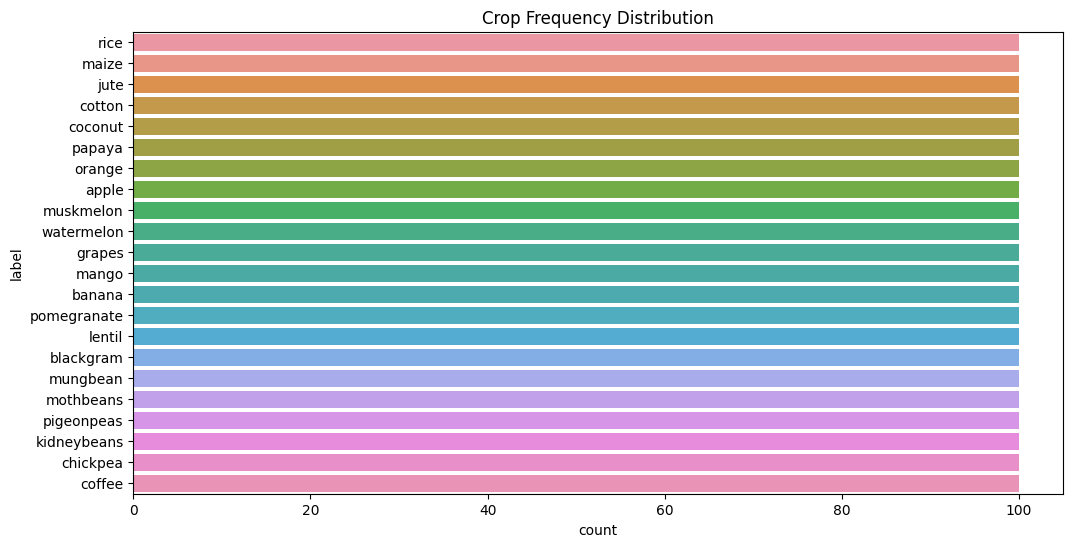

In [9]:
#Target Variable Distribution 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.countplot(y=data['label'], order=data['label'].value_counts().index)
plt.title("Crop Frequency Distribution")
plt.show()


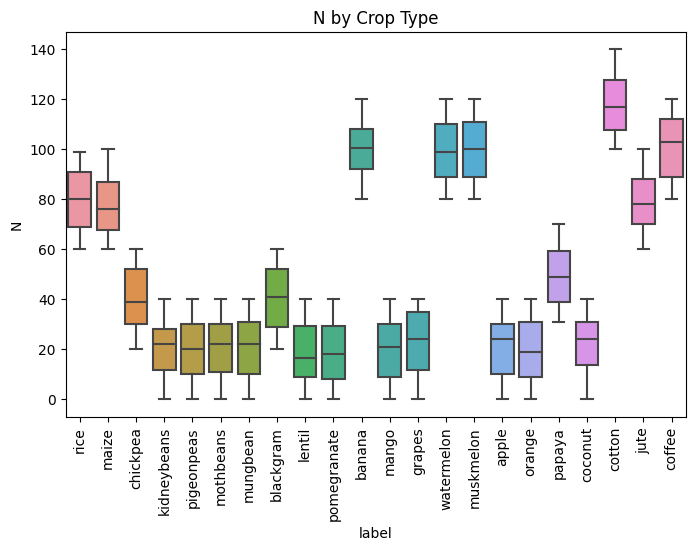

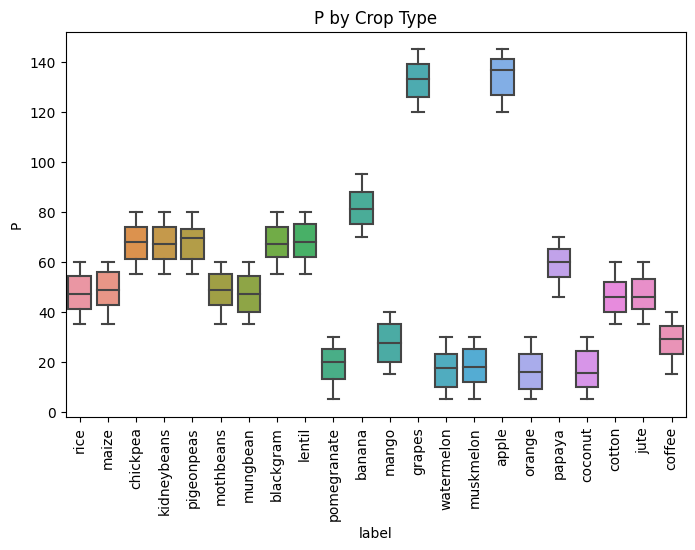

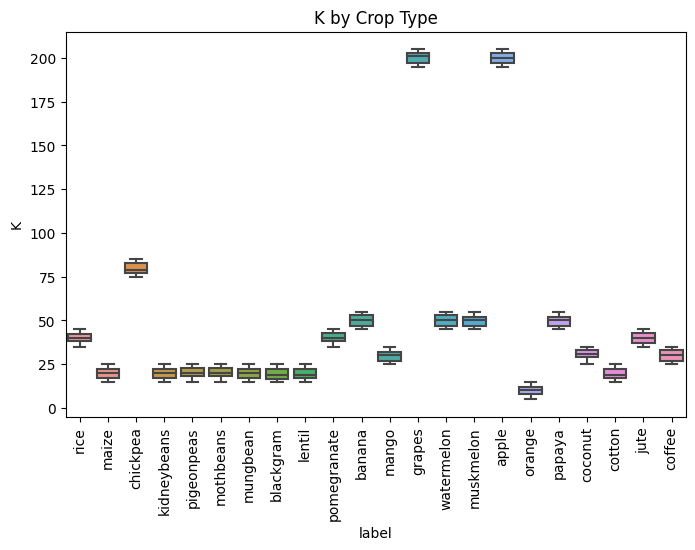

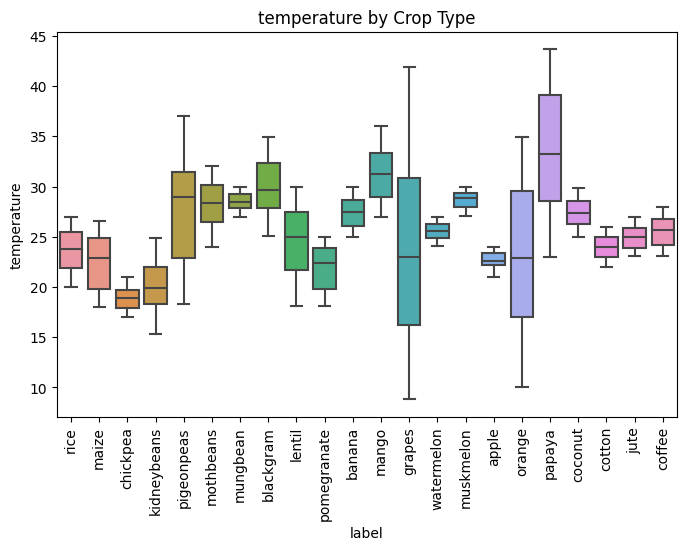

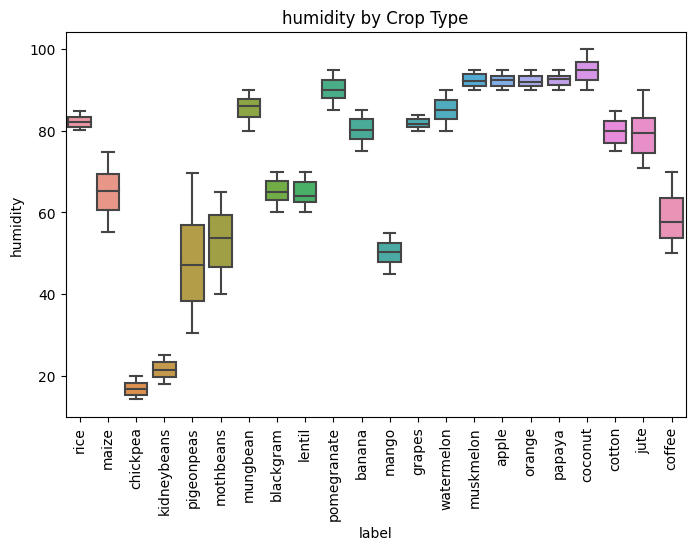

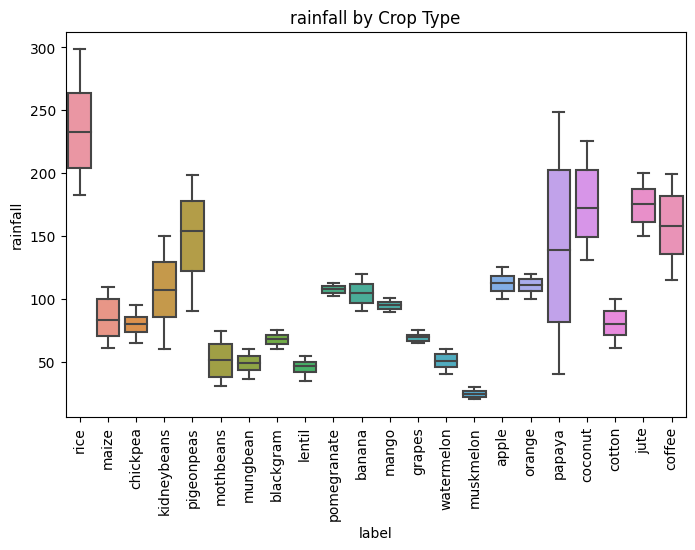

In [11]:
#Relationship between Variables and Target
for col in ['N', 'P', 'K', 'temperature', 'humidity', 'rainfall']:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='label', y=col, data=data)
    plt.xticks(rotation=90)
    plt.title(f"{col} by Crop Type")
    plt.show()


In [13]:
try:
    from ydata_profiling import ProfileReport
    profile = ProfileReport(data)
    profile.to_file("report.html")
except ImportError:
    print("ydata-profiling not installed in this environment.")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:00<00:00, 118.90it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
from IPython.display import IFrame
IFrame(src="report.html", width=1000, height=600)


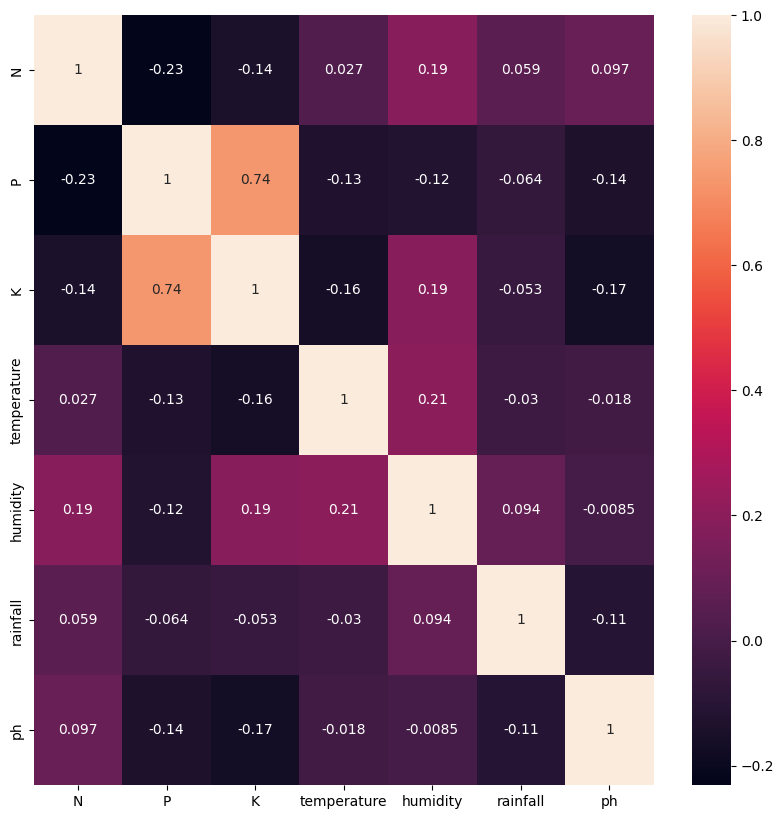

In [36]:
plt.figure(figsize=(10,10))
input=data[["N","P","K","temperature","humidity","rainfall","ph"]]
sns.heatmap(input.corr(),annot=True)
plt.show()

In [47]:
X = data.drop(columns=['label'])  # features
y = data['label']                 # target (crop name)
le =LabelEncoder()

In [39]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [40]:
X_train.head


<bound method NDFrame.head of         N    P    K  temperature   humidity        ph    rainfall
1656   17   16   14    16.396243  92.181519  6.625539  102.944161
752    37   79   19    27.543848  69.347863  7.143943   69.408782
892     7   73   25    27.521856  63.132153  7.288057   45.208411
1041  101   70   48    25.360592  75.031933  6.012697  116.553145
1179    0   17   30    35.474783  47.972305  6.279134   97.790725
...   ...  ...  ...          ...        ...       ...         ...
1638   10    5    5    21.213070  91.353492  7.817846  112.983436
1095  108   94   47    27.359116  84.546250  6.387431   90.812505
1130   11   36   31    27.920633  51.779659  6.475449  100.258567
1294   11  124  204    13.429886  80.066340  6.361141   71.400430
860    32   78   22    23.970814  62.355576  7.007038   53.409060

[1760 rows x 7 columns]>

In [41]:
y_train.head

<bound method NDFrame.head of 1656       orange
752     blackgram
892        lentil
1041       banana
1179        mango
          ...    
1638       orange
1095       banana
1130        mango
1294       grapes
860        lentil
Name: label, Length: 1760, dtype: object>

In [48]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
y_train_scaled=le.fit_transform(y_train)
y_test_scaled=le.transform(y_test)

In [52]:
XGB=xgb.XGBClassifier()
XGB.fit(X_train,y_train_scaled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [55]:
y_test_pred=XGB.predict(X_test)
score=accuracy_score(y_test_scaled,y_test_pred)
print(score)

0.9863636363636363


In [59]:
cm = confusion_matrix(y_test_scaled, y_test_pred)
print(cm)

[[23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0 23  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0

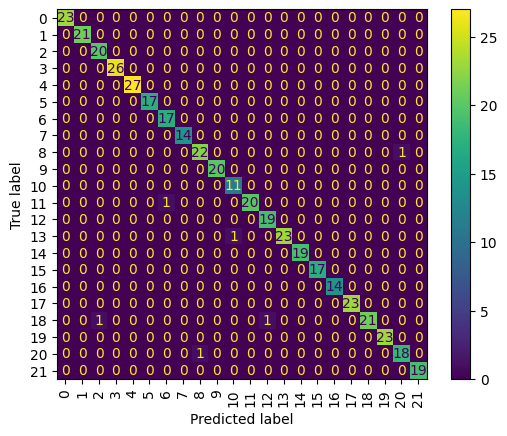

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical')

In [62]:
with open("crop_model.pkl", "wb") as f:
    pickle.dump(XGB, f)  


In [63]:
import os
print(os.listdir())


['.virtual_documents', 'report.html', 'crop_model.pkl']
